# 0: Setup Environment

## Load modules and custom functions

In [1]:
# --- Environment Setup ---
import sys, os
# insert the parent folder of `notebooks/` as the first place to look for modules
sys.path.insert(0, os.path.abspath('..'))

import sys
from pathlib import Path

from pys.utils.ml_utilities import *

import pandas as pd
import numpy as np

import time
import numpy as np
import pandas as pd
import polars as pl, pyarrow # required for polars file reading

# load custom functions
from pys import *
from pys.utils import *

from pprint import pprint

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# import sklearn libraries
from sklearn import set_config
set_config(display='diagram')  # for better visualization of sklearn pipelines
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_validate

# import xgboost libraries
import optuna
import xgboost as xgb # for GPU XGBoost
from xgboost import XGBRegressor, XGBClassifier
# from xgboost import plot_importance, plot_tree, plot_xgboost

# import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectFromModel

# import joblib for saving models
import joblib # for saving models

import random

# import warnings to ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Function to check if an NVIDIA GPU is present
def check_nvidia_cupy_present():
    try:
        import cupy as cp  # Import cupy to check for GPU availability
        if cp.cuda.runtime.getDeviceCount() > 0:
            return True
    except ImportError:
        print("cupy is not installed. GPU support will not be available.")
    except Exception as e:
        print(f"An error occurred while checking for GPU: {e}")
    return False

def get_gpu_if_present():
    # Check for NVIDIA GPU presence
    print("Checking for NVIDIA GPU...")
    if check_nvidia_cupy_present():
        print("NVIDIA GPU detected. Using GPU for XGBoost training.")
        NVIDIA_GPU = True # Set to True if you have an NVIDIA GPU and want to use it for training
        # Set the XGBoost parameters to use GPU
        xgb_params_cpu_gpu = {
            'tree_method': 'gpu_hist',  # Use GPU for training
            'predictor': 'gpu_predictor',  # Use GPU for prediction
            'gpu_id':            0,
        }          
    else:
        print("No NVIDIA GPU detected or not available. Using CPU for XGBoost training.")
        NVIDIA_GPU = False
        # Set the XGBoost parameters to use CPU
        xgb_params_cpu_gpu = {
            'tree_method': 'hist',  # Use CPU for training
            'predictor': 'cpu_predictor',  # Use CPU for prediction
        }
    return NVIDIA_GPU, xgb_params_cpu_gpu

## Define Functions

In [3]:
# function for turning regression predictions into binary predictions
def convert_reg_pred_to_binary(df, y_pred, threshholds):
#   • regression ⇒ class  (hard)
    df["binary_reg_pred"] = (
        y_pred < df["drug_id"].map(threshholds)
    ).astype(int)

    return df["binary_reg_pred"]

## Set notebook parameters

In [4]:
# Set the directory for saving models
ROOT = Path.cwd().resolve()  # assumes notebook is run from repo root or subdir
if ROOT.name == 'notebooks':
    ROOT = ROOT.parent  # go up one level if in notebooks directory


DATA_DIR = ROOT / 'data'

MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = ROOT / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Set a random seed for reproducibility
# This is crucial for ensuring your splits and model training are consistent
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

ROUND_TO = 3 # decimal places to round to



# Check if an NVIDIA GPU is present and set the XGBoost parameters accordingly
NVIDIA_GPU = False  # Default to False, will be set to True if GPU is detected
xgb_params_cpu_gpu = {}  # Default parameters for CPU

# Call the function to check for GPU and set parameters
NVIDIA_GPU, xgb_params_cpu_gpu = get_gpu_if_present()


Checking for NVIDIA GPU...
cupy is not installed. GPU support will not be available.
No NVIDIA GPU detected or not available. Using CPU for XGBoost training.


# 1: Load Data & Add Weights

## 1.1: Load data from .h5

In [5]:
# load data form file 
with pd.HDFStore(DATA_DIR / 'gbdc_blocks_w_lookups_2.h5', mode='r') as store:
    drug_lookup = store['drug_lookup']
    drug_df = store['drug_df']
    dose_df = store['dose_df']
    cell_lookup = store['cell_lookup']
    # cell    = store['cell_block']
    # ic50    = store['ic50_block']
    # zscore  = store['zscore_block']
    # meth    = store['meth_block']
    # mut     = store['mut_block']
    # expr    = store['expr_block']
    df_merged = store['df_merged']
    # add column information in list format

## 1.2: Get column headers by dataset for trained models on different data sets (per table below)

The following combination of data sets will be used to evaluate the contribution of methylation, mutation and expression to with the GDSC on model performance.

| 	Condition	 | 	GDSC	 | 	Methylation (M)	 | 	Mutation (V)	 | 	Expression (E)	 | 
| 	--------	 | 	-----------	 | 	--------	 | 	-----------	 | 	----------	 | 
| 	Impact of GDSC only *	 | 	Y	 | 		 | 		 | 		 | 
| 	Impact of GDSC with M	 | 	Y	 | 	Y	 | 		 | 		 | 
| 	Impact of GDSC with M + V	 | 	Y	 | 	Y	 | 	Y	 | 		 | 
| 	Impact of GDSC with  M + E	 | 	Y	 | 	Y	 | 		 | 	Y	 | 
| 	Impact of GDSC with  M + V + E	 | 	Y	 | 	Y	 | 	Y	 | 	Y	 | 
* Used for Base Models and Selection of the Best Model		

In [6]:
# load data form file 
with pd.HDFStore(DATA_DIR / 'gbdc_blocks_w_lookups_2.h5', mode='r') as store:
    cols_C  = store['cols_C'].tolist()
    cols_T  = store['cols_T'].tolist()
    cols_M  = store['cols_M'].tolist()
    cols_V  = store['cols_V'].tolist()
    cols_E  = store['cols_E'].tolist()
    cols_CM = store['cols_CM'].tolist()
    cols_CMV = store['cols_CMV'].tolist()
    cols_CME = store['cols_CME'].tolist()
    cols_CMVE = store['cols_CMVE'].tolist()

# 1.3:  Add weights for training, based on rsme of ln_ic50 measurement
Weights will be evaluated on one model for utility in model performace. It is anticipated that weights will have a postiive impact on performance by weighting higher confident ln_ic50 scores over lower socres during supervised training.

In [7]:
# add weights
eps = 1e-4 # prevents divide by zero
df_merged['w'] = 1/(df_merged.rmse + eps)

# clip the very largest weights so no single assay dominates
clip_q = df_merged["w"].quantile(0.99)
df_merged["w"] = df_merged["w"].clip(upper=clip_q)

# Normalise so mean weight ≈ 1 (keeps loss magnitude stable)
df_merged['w'] /= df_merged['w'].mean()

# add weight column to the target columns list
cols_T = cols_T + ['w']


# 2: Data Splitting - Drug-Wise Stratified Unseen Cell Line Split

## 2.1 Split Cell Lines into Training and Test Sets (80:20)

In [8]:
#  Data Splitting - Drug-Wise Stratified Unseen Cell Line Split ---
print("\n--- Starting Data Splitting ---")

# Identify Unique Cell Lines
unique_cell_lines = df_merged['COSMIC_ID'].unique()
print(f"Total unique cell lines: {len(unique_cell_lines)}")

# # Split Cell Lines into Training and Test Sets (80:20)
gss = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state=RANDOM_SEED)
train_idx, val_idx = next(gss.split(df_merged, groups=df_merged['COSMIC_ID']))

df_train = df_merged.iloc[train_idx].copy()
df_val   = df_merged.iloc[val_idx].copy()

# 2. Ensure every drug appears in validation
missing_drugs = set(df_merged['drug_id']) - set(df_val['drug_id'])
if missing_drugs:
    print("Warning: these drugs are absent from validation", missing_drugs)



--- Starting Data Splitting ---
Total unique cell lines: 912


## 2.2: Add binary target for ln_ic50 to train and evaluate classification models


In [9]:
# Add binary targets to training and validation sets for classification models
# derive cut-off(s) from training dataset only
threshhold_per_drug = (
    df_train.groupby('drug_id')['ln_ic50']  # could use z_score
    .quantile(0.25) # 25% is most sensitive
    .to_dict()
    )

# save thresholds for later
joblib.dump(threshhold_per_drug, MODELS_DIR / "ln_ic50_binary_cutoffs_per_drug.pkl")

# make binary target labels for classifier models
for df in (df_train, df_val):
    df['binary_ln_ic50'] = df.apply(
        lambda r: int(r.ln_ic50 < threshhold_per_drug[r.drug_id]), axis=1
    )

# update target columns with binary_ln_ic50
cols_T = cols_T + ['binary_ln_ic50']


## 2.3 Create Development Training and Validation DataFrames

### Set the target column
This emables evaluating ln_ic50, auc and z_score as targets.


In [10]:
# Define features and target
TARGET_COLUMN_REG = 'ln_ic50'
TARGET_COLUMN_CAT = 'binary_ln_ic50'

TARGET_RELATED_FEATURES =  cols_T #['ln_ic50', 'auc', 'z_score', 'rmse', 'w'] # Exclude from training sets

In [11]:
# Create Training and Test DataFrames 

# make X_train/_y and test_X/y
drop_cols_for_X = ['drug_id', 'COSMIC_ID'] + TARGET_RELATED_FEATURES
print(f"Drop columns from X: {drop_cols_for_X}\n")

# training data set
X_train = df_train.drop(columns=drop_cols_for_X)



# Drop columns cols_C not in X_train
cols_C = [col for col in X_train.columns if col in cols_C]  # ensure core features are included

# setup y_train for regression and classification
y_train_reg = df_train[TARGET_COLUMN_REG].copy() # or 'auc' or 'zscore 
y_train_cat = df_train[TARGET_COLUMN_CAT].copy() # for classifier models

# # Get numeric and object columns for plotting
# numeric_cols = df_train.select_dtypes('number').columns.to_list()
# object_cols = df_train.select_dtypes('object').columns.to_list()
# #pprint(numeric_cols)

# validation dataset
X_val = df_val.drop(columns=drop_cols_for_X)

# setup y_val for regression and classification
y_val_reg = df_val[TARGET_COLUMN_REG].copy() # for regression models (or use 'auc' or 'zscore)
y_val_cat = df_val[TARGET_COLUMN_CAT].copy() # for classifier models

# get weights (from RMSE) for training and validation sets
# These are used to weight the loss function during training
w_train = df_train['w'].copy().values.astype("float32")
w_val = df_val['w'].copy().values.astype("float32")

feature_columns = X_train.columns
print(f"X_train shape: {X_train.shape}, y_train_reg shape: {y_train_reg.shape}")
print(f"X_val shape:   {X_val.shape},   y_test shape:      {y_val_reg.shape}")

#print(f"\nFeatures used for modeling:")
#pprint(feature_columns.to_list())


Drop columns from X: ['drug_id', 'COSMIC_ID', 'ln_ic50', 'auc', 'z_score', 'rmse', 'w', 'binary_ln_ic50']

X_train shape: (178951, 1212), y_train_reg shape: (178951,)
X_val shape:   (45153, 1212),   y_test shape:      (45153,)


### Confirm drugs are distributed across train and validation

In [12]:

# Verify Drug Coverage in Validation Set
# This is crucial to ensure "test set still contains potency measurements for each compound"
all_drugs = df_merged['drug_id'].unique()
drugs_in_train = df_train['drug_id'].unique()
drugs_in_val = df_val['drug_id'].unique()

missing_from_val = set(all_drugs) - set(drugs_in_val)
missing_from_train = set(all_drugs) - set(drugs_in_train)

if len(missing_from_val) > 0:
    print(f"\nWARNING: The following drugs are MISSING from the VALIDATION set: {missing_from_val}")
    print("This means the random cell line split resulted in some drugs having no data in the validation set.")
    print("Consider re-running the split or adjusting the validation set if this is critical for all drugs.")
else:
    print("\nAll drugs are present in the Validation set. Good!")

if len(missing_from_train) > 0:
    print(f"\nWARNING: The following drugs are MISSING from the TRAINING set: {missing_from_train}")
    print("This is less common but indicates some drugs might only appear in the validation set.")
else:
    print("All drugs are present in the TRAINING set. Good!")


All drugs are present in the Validation set. Good!
All drugs are present in the TRAINING set. Good!


## 2.4 Check the distribution of cell lines in train and test by cell features

Is there a similar distribution of cell line types (tissue, cancer_type) in train and test

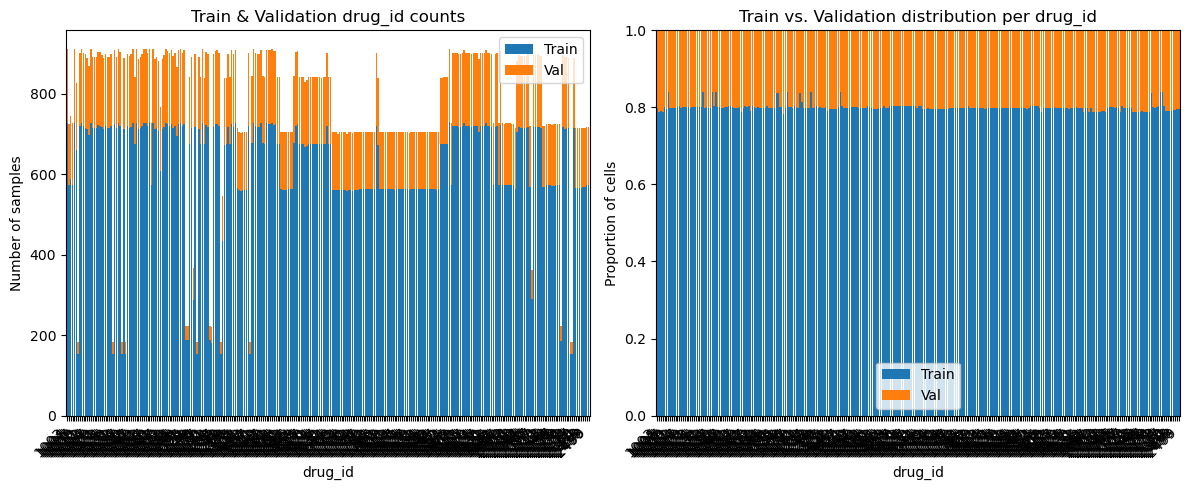

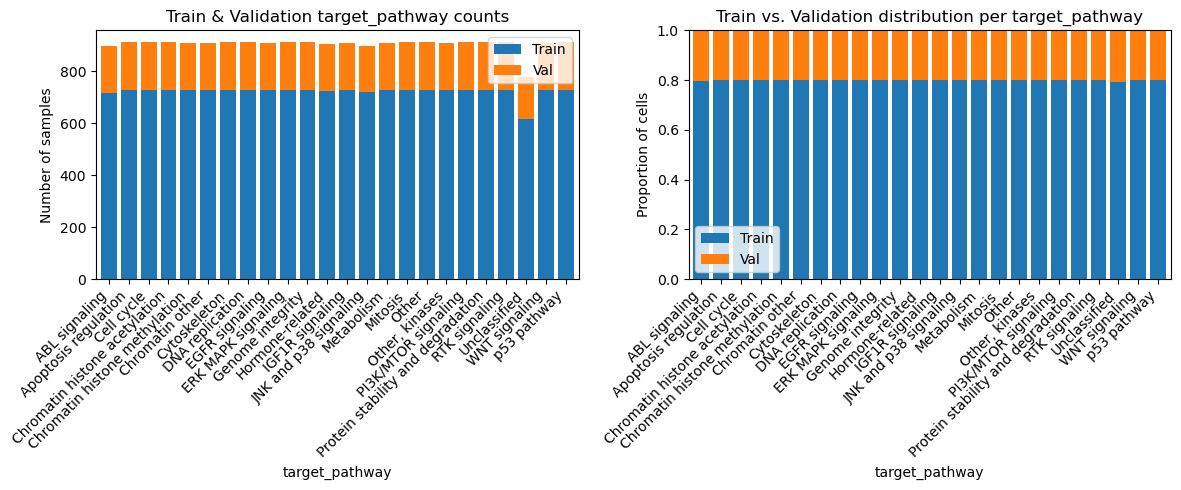

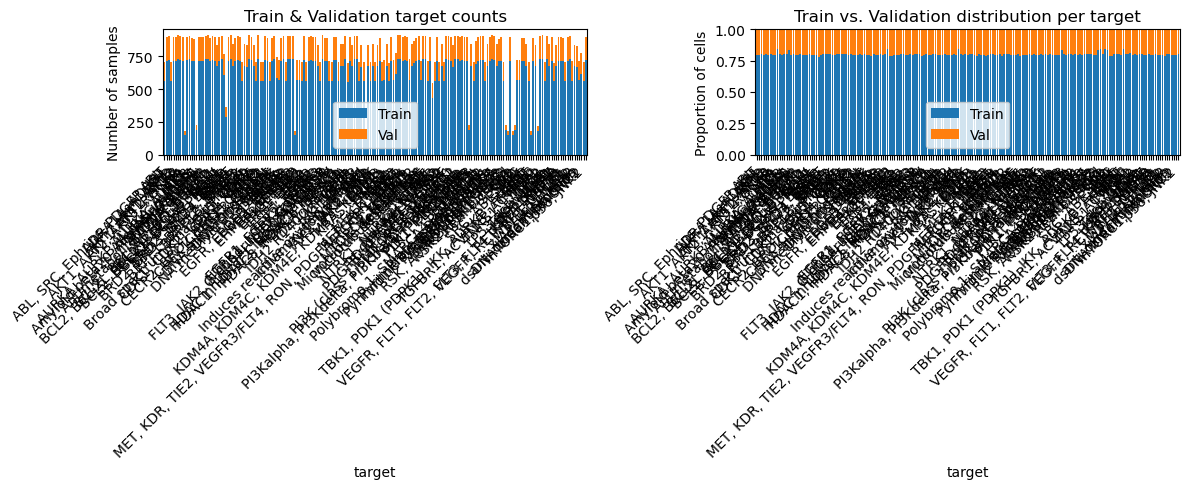

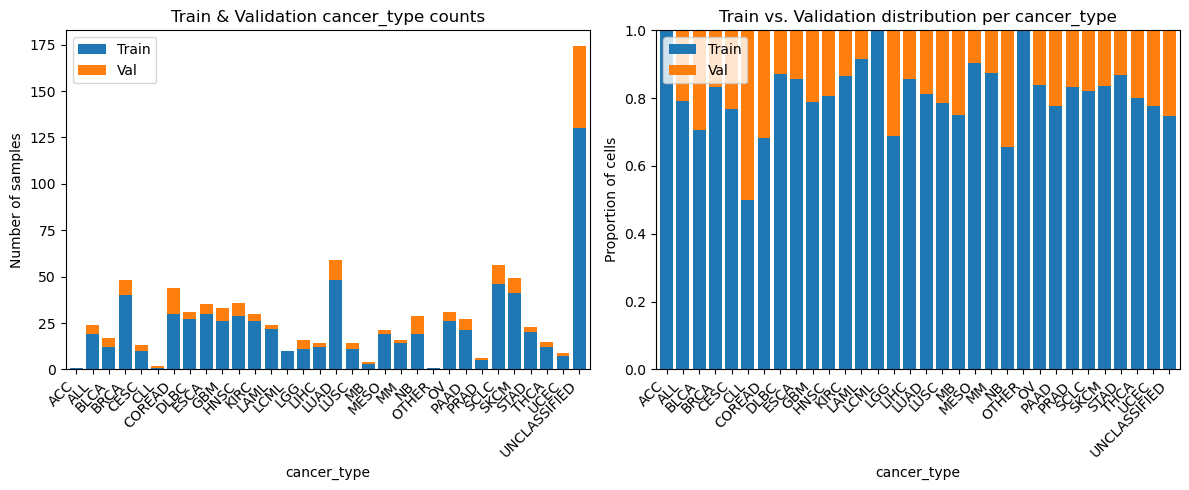

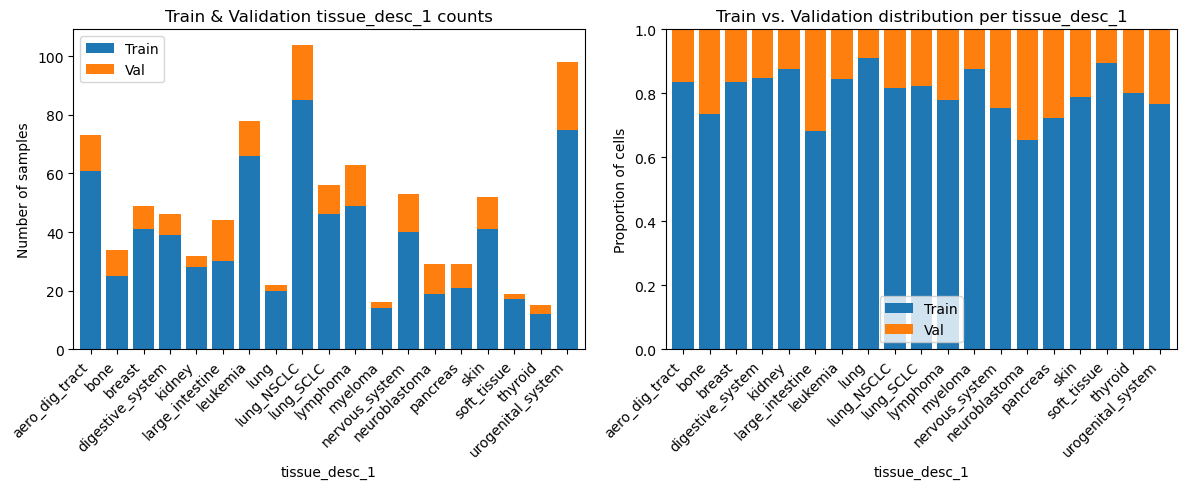

In [13]:
# Plot numbers and ratios for various features in train and test
feature_list = 'drug_id', 'target_pathway', 'target', 'cancer_type', 'tissue_desc_1'

for feature in feature_list:
    # Compute the distribution (absolute counts) in each set
    train_counts = df_train.groupby(feature)['COSMIC_ID'].nunique()
    val_counts  = df_val.groupby(feature)['COSMIC_ID'].nunique()

    # Right Plot: ratio of test:train / feature
    stacked_df = pd.DataFrame({
        'Train': train_counts,
        'Val':  val_counts
    })

    # nomalize by counts per each type 
    df_norm = stacked_df.div(stacked_df.sum(axis=1), axis=0)

    # Plot
    fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)

    # left: raw counts
    stacked_df.plot.bar(stacked=True, ax=axes[0], width=0.8)
    axes[0].set_title(f"Train & Validation {feature} counts")
    axes[0].set_ylabel("Number of samples")
    axes[0].legend()

    for lbl in axes[0].get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')

    # right: normalized proportions
    df_norm.plot(kind='bar', stacked=True, ax=axes[1], width=0.8) #, color=['blue', 'red'])
    axes[1].set_title(f"Train vs. Validation distribution per {feature}")
    axes[1].set_ylabel("Proportion of cells")
    axes[1].set_ylim(0, 1)

    #axes[1].legend(title="Dataset", loc="upper right")
    #axes[1].tick_params(axis='x', rotation=45, labelsize='small')
    for lbl in axes[1].get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')

    plt.tight_layout()
    plt.show()


In [14]:


# # 1) value counts for each feature
# ct_counts  = df_merged['cancer_type'].value_counts()
# td1_counts = df_merged['tissue_desc_1'].value_counts()

# # 2) combine into one DF
# compare = pd.DataFrame({
#     'cancer_type':  ct_counts,
#     'tissue_desc_1': td1_counts
# }).fillna(0).astype(int)

# # 3a) compute a ratio column if you like
# compare['ratio_ct_to_td1'] = compare['cancer_type'] / compare['tissue_desc_1'].replace(0, pd.NA)

# print(compare)

# side-by-side bar chart
# fig, ax = plt.subplots(figsize=(8,6))
# compare.plot.bar(
#     y=['cancer_type','tissue_desc_1'],
#     ax=ax
# )
# ax.set_ylabel("Count")
# ax.set_title("Counts by Category: cancer_type vs tissue_desc_1")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()


### Is there an unbalanced number of cancer types per tissue_desc_1?

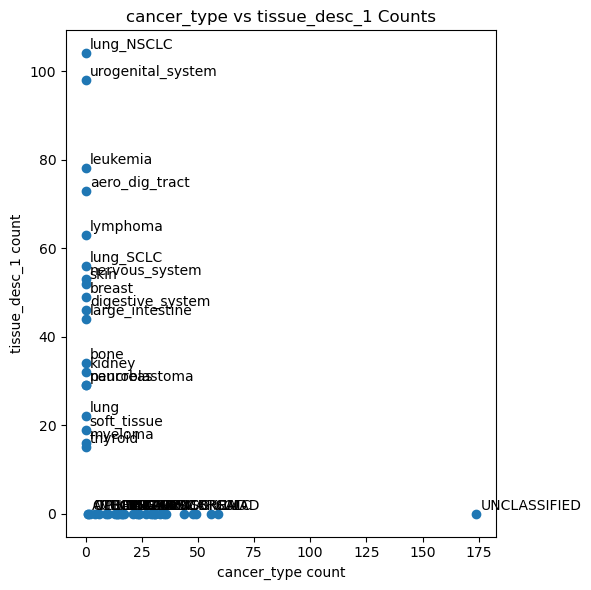

In [15]:
# 1) Get the first value of each feature per COSMIC_ID
ct_per_cell = df_merged.drop_duplicates('COSMIC_ID').set_index('COSMIC_ID')['cancer_type']
td1_per_cell = df_merged.drop_duplicates('COSMIC_ID').set_index('COSMIC_ID')['tissue_desc_1']

# 2) Count occurrences of each category
ct_counts = ct_per_cell.value_counts()
td1_counts = td1_per_cell.value_counts()

# 3) Combine into one DataFrame
compare = pd.DataFrame({
    'cancer_type': ct_counts,
    'tissue_desc_1': td1_counts
}).fillna(0).astype(int)

# 4) Compute ratio column
compare['ratio_ct_to_td1'] = compare['cancer_type'] / compare['tissue_desc_1'].replace(0, pd.NA)

# 5) Plot
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(compare['cancer_type'], compare['tissue_desc_1'])
for lbl, row in compare.iterrows():
    ax.annotate(lbl, (row['cancer_type'], row['tissue_desc_1']),
                textcoords="offset points", xytext=(3,3))
ax.set_xlabel("cancer_type count")
ax.set_ylabel("tissue_desc_1 count")
ax.set_title("cancer_type vs tissue_desc_1 Counts")
plt.tight_layout()
plt.show()


### How does the binary compare to ln_50, auc and z_score (in total and by drug)


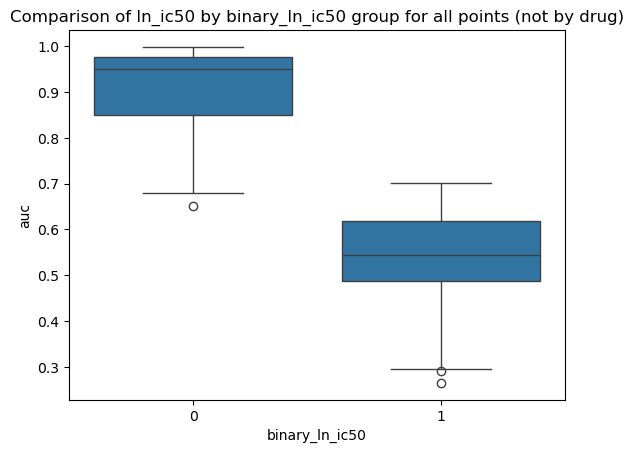

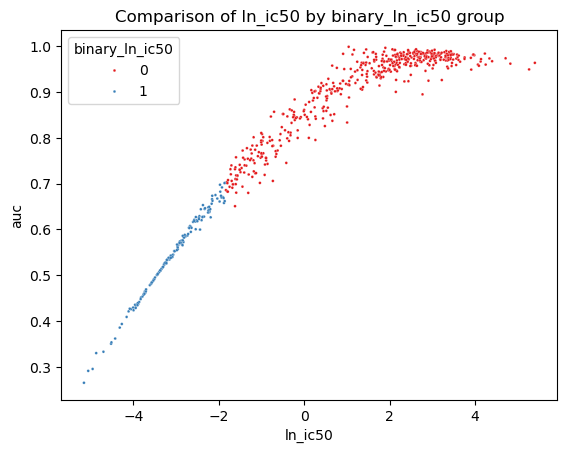

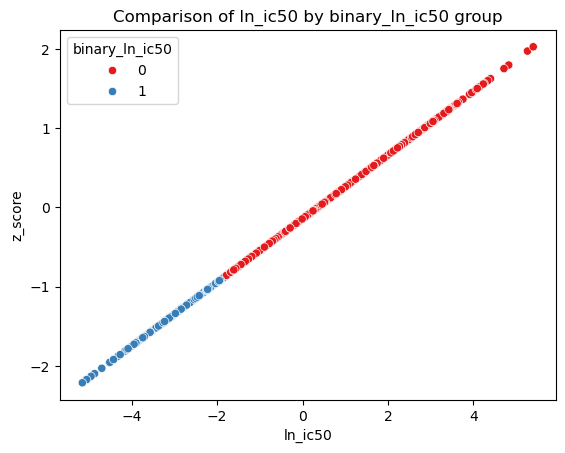

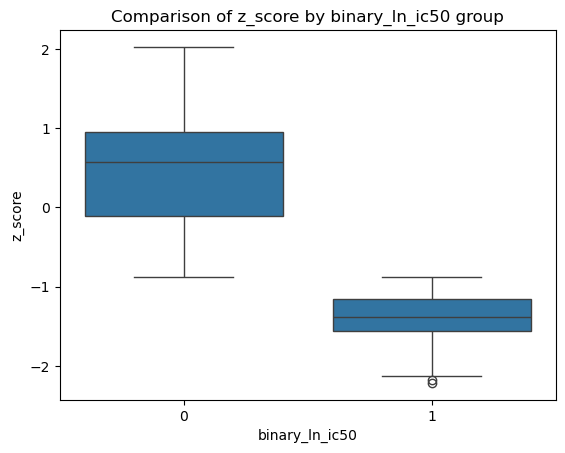

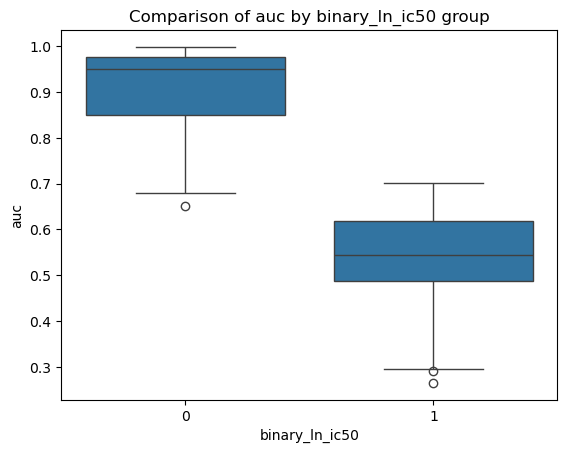

In [16]:
## plot binary_ln_ic50 by drug_id
# Filter for a specific drug_id, e.g., 1008

df_plot = df_train[df_train['drug_id'] == 1008]

# cmopare
xval='binary_ln_ic50'
yval='auc'
sns.boxplot(x=xval, y=yval, data=df_plot)
plt.title("Comparison of ln_ic50 by binary_ln_ic50 group for all points (not by drug)")
plt.xlabel(xval)
plt.ylabel(yval)
plt.show()

# df_merged.plot.scatter(x='ln_ic50', y='z_score')
xval='ln_ic50'
yval='auc'
sns.scatterplot(x=xval, y=yval, hue='binary_ln_ic50',  s=4,  data=df_plot, palette='Set1')
plt.title("Comparison of ln_ic50 by binary_ln_ic50 group")
plt.xlabel(xval)
plt.ylabel(yval)
plt.show()

# df_merged.plot.scatter(x='ln_ic50', y='z_score')
xval='ln_ic50'
yval='z_score'
sns.scatterplot(x=xval, y=yval, hue='binary_ln_ic50', data=df_plot, palette='Set1')
plt.title("Comparison of ln_ic50 by binary_ln_ic50 group")
plt.xlabel(xval)
plt.ylabel(yval)
plt.show()

# Plot z_score distributions for each binary_ln_ic50 group on the same plot
xval='binary_ln_ic50'
yval='z_score'
sns.boxplot(x='binary_ln_ic50', y='z_score', data=df_plot)
plt.title("Comparison of z_score by binary_ln_ic50 group")
plt.xlabel(xval)
plt.ylabel(yval)
plt.show()

xval='binary_ln_ic50'
yval='auc'
sns.boxplot(x='binary_ln_ic50', y='auc', data=df_plot)
plt.title("Comparison of auc by binary_ln_ic50 group")
plt.xlabel(xval)
plt.ylabel(yval)
plt.show()

### Is there ambiguity in the binary_ln_ic5o 0-1 cuttoff on a per drug basis?
Plot will show that half of the drugs have > x% of samples in the ambiguous zone (overlap) between 0-1. And what the standard de

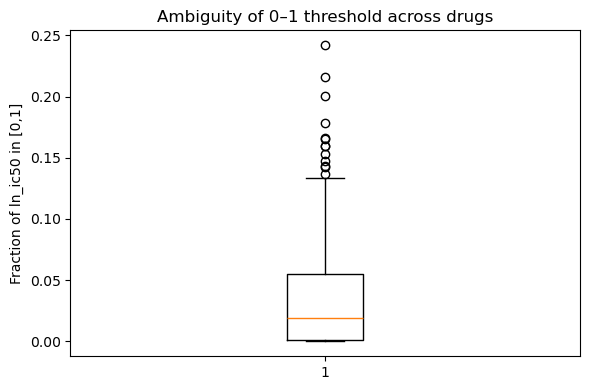

In [17]:
# compute overlap fraction per drug
def overlap_frac(g):
    mask = (g['ln_ic50'] >= 0.5) & (g['ln_ic50'] <= 1)
    return mask.sum() / len(g)

overlap = df_merged.groupby('drug_id').apply(overlap_frac)

# box-plot the distribution across drugs
fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot(overlap.values)
ax.set_ylabel("Fraction of ln_ic50 in [0,1]")
ax.set_title("Ambiguity of 0–1 threshold across drugs")
plt.tight_layout()
plt.show()

In [18]:
# ## IGNORE

# ### Calculate Cohen's d for each drug
# # Cohen's d is a measure of effect size that indicates the standardized difference between two means.
# # Here, we will calculate Cohen's d for the ln_ic50 values, comparing the lower
# def cohens_d(g):
#     s = g['ln_ic50']
#     thr = s.quantile(0.25)
#     low, high = s[s<thr], s[s>=thr]
#     n1, n2 = len(low), len(high)
#     # pooled std
#     s_pooled = np.sqrt(((n1-1)*low.std()**2 + (n2-1)*high.std()**2) / (n1+n2-2))
#     return (high.mean() - low.mean()) / s_pooled

# d_scores = df_merged.groupby('drug_id').apply(cohens_d)
# d_scores.describe()

**Interpretation:**
- even split 80:20 across values of drug related features
- uneven split across values of cell related cancer type and tissue descriptions. 
- There is a very small overlap in ln_50 across drugs at the cuttoff of 0/1 threshold for binary seperation

Next:
- Future study: Try splitting based on cell features (not to be done in this notebook)
- Should the cancers be combined into other if below a specific fequency? 

## 2.4 Evaluate distribution of target metrics in train and validation datasets

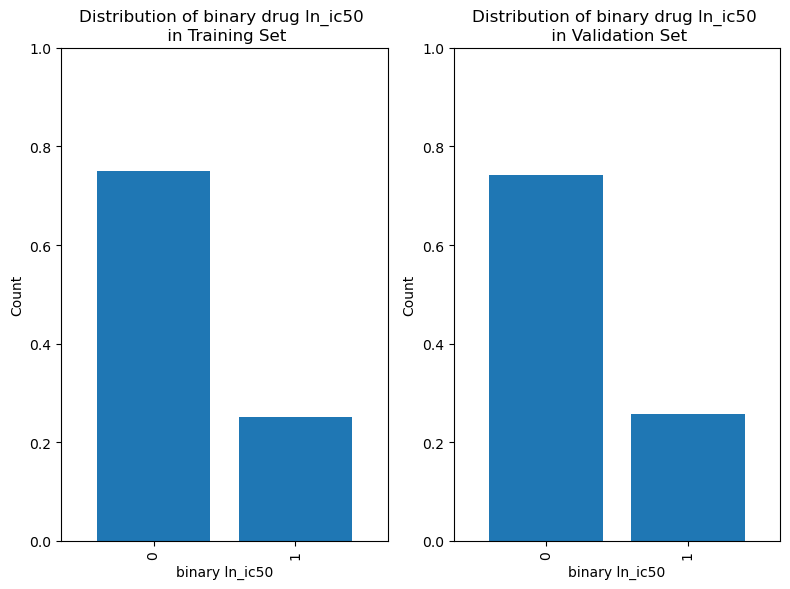

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))

train_pct = df_train[TARGET_COLUMN_CAT].value_counts(normalize=True)
train_pct.plot(kind='bar', stacked=False, ax=ax[0], width=0.8,  ylim=(0, 1) )
ax[0].set_title("Distribution of binary drug ln_ic50 \n in Training Set")
ax[0].set_xlabel("binary ln_ic50")
ax[0].set_ylabel("Count")

val_pct = df_val[TARGET_COLUMN_CAT].value_counts(normalize=True)
val_pct.plot(
    kind='bar', stacked=False, ax=ax[1], 
    width=0.8, ylim=(0, 1)
    )

ax[1].set_title("Distribution of binary drug ln_ic50 \n in Validation Set")
ax[1].set_xlabel("binary ln_ic50")
ax[1].set_ylabel("Count")
#plt.savefig(RESULTS_DIR / 'binary_ln_ic50_train_dist.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

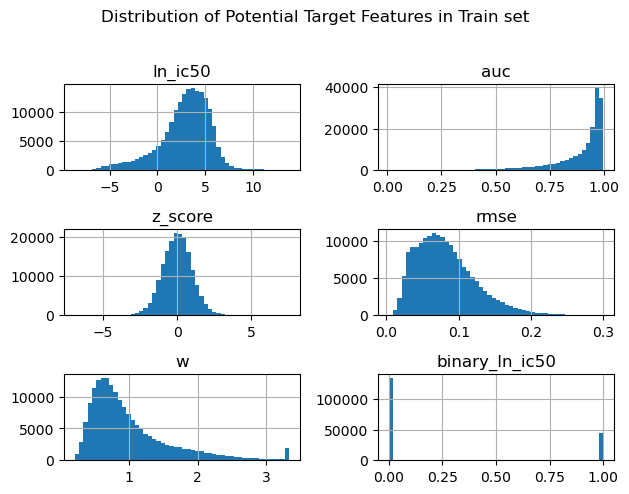

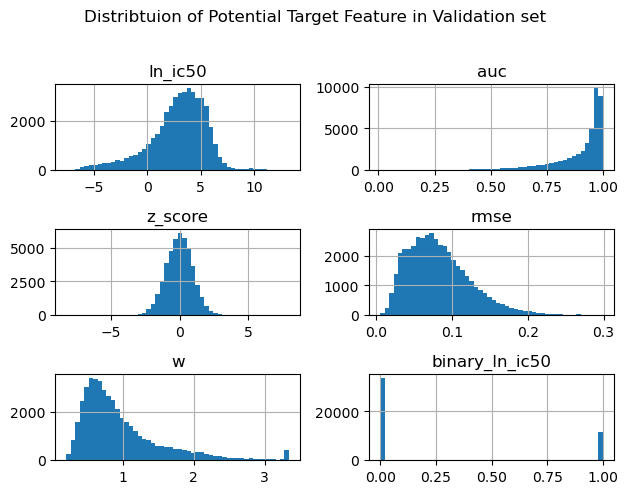

In [20]:
df_train.hist(column=TARGET_RELATED_FEATURES, bins=50)
plt.suptitle('Distribution of Potential Target Features in Train set', y=1.02)
plt.tight_layout()
plt.show()


df_val.hist(column=TARGET_RELATED_FEATURES, bins=50)
plt.suptitle('Distribtuion of Potential Target Feature in Validation set', y=1.02)
plt.tight_layout()
plt.show()


### Explore skew in ln_ic50

In [21]:
# Print metrix for ln_ic50
display(df_train['ln_ic50'].describe().round(3))

count    178951.000
mean          2.860
std           2.718
min          -8.643
25%           1.551
50%           3.257
75%           4.705
max          13.820
Name: ln_ic50, dtype: float64

#### Does the use of weights result in a more normal distribution?

count    659.000
mean       0.655
std        2.017
min       -5.197
25%       -0.869
50%        0.324
75%        1.718
max        8.127
Name: normalized, dtype: float64

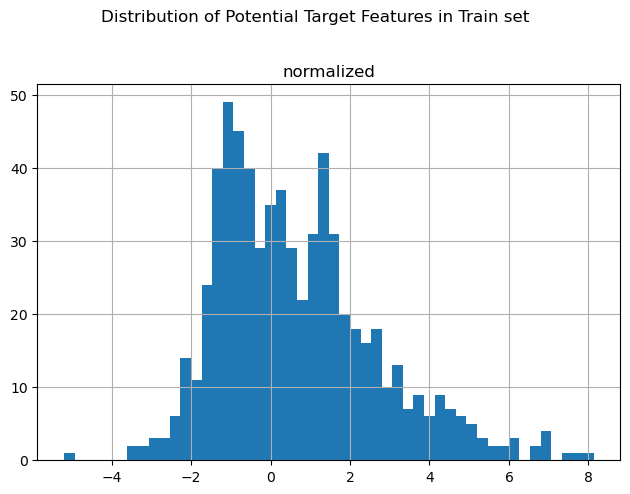

In [22]:
# distribution of weighted ln_ic50 during training
df_plot['normalized'] = df_train['ln_ic50'] * df_train['w']
display(df_plot['normalized'].describe().round(3))

df_plot.hist(column='normalized', bins=50)
plt.suptitle('Distribution of Potential Target Features in Train set', y=1.02)
plt.tight_layout()
plt.show()



**Interpretation:**
- The ln_ic50 is skewed right. 
- Normalization of the ln_ic50 with the rmse derived weights does enough normalizaiton not to warent normalization ahead of NN model training.

Next:
- Models other than neural networks (NN) do not need normalization of the ln_ic50
- The neural network model will likely do better with normalized target ln_ic50, so normalization will be implemented.

# 3. Baseline Models
Get baseline performance for a Linear and Dummy model to compare optimized models to.

## 3.0 Set up metric capture for model evaluations

### Setup tracking of model evaluatoin information
- df_models_eval: capture metrics in table (AUC, RMSE, ACCURACY, etc .....)
- df_bounds: Capture lower, upper, quantial information in a table.

In [23]:
# Initiate df_models_eval for capturing model performance metrics
df_models_eval = evaluate_model()
#print_df_markdown(df_models_eval)

# track calcualated bounds for each numeric  feature analyzed
df_bounds = pd.DataFrame(columns=[
    'feature', 'lower', 'upper', 'q1', 'q3', 'iqr'
    ])

# Initiate df_model_info for capturing model information
# This will be used to store information about each model trained
df_model_info   = pd.DataFrame({
    'model_name': [],
    'model_type': [],
    'task_type':  [],
    'feature_set': [],
    'target_column': [],
    'train_data_X':  [],
    'train_data_y':  [],
    'val_data_X': [],
    'val_data_y': [],
    'train_sample_weights': [],
    'val_sample_weights': [],
    'model_description': []
    })


In [ ]:
# Cereate a preprocessor
def get_preprocessor(X_train, cols_use):
    """
    Create a preprocessor for the specified columns in cols_use.

    This function creates a preprocessor for the specified columns in cols_use.
    It handles numerical and categorical features separately, applying appropriate transformations.
    The preprocessor can then be used in a machine learning pipeline to ensure consistent preprocessing of training
    and validation data.
    It uses SimpleImputer for missing values and StandardScaler for numerical features, while OneHotEncoder is used for categorical features.
    The ColumnTransformer combines these transformations, allowing for a flexible preprocessing

    Args:
        X_train (pd.DataFrame): The training data containing the features.
        cols_use (list or str): The columns to preprocess. If a string is provided, it will be converted to a list.

    Returns:
        preprocessor (ColumnTransformer): A preprocessor that can be used in a machine learning pipeline
        to transform the specified columns in X_train.
    Raises:
        ValueError: If cols_use is empty or if any specified columns are not found in X_train.
    """
    # Check if cols_use is empty
    if cols_use is None or (isinstance(cols_use, list) and not cols_use):
        raise ValueError("cols_use cannot be None or empty. Please provide columns to preprocess.")
    elif isinstance(cols_use, pd.Series):
        cols_use = cols_use.tolist()    

    # Ensure cols_use is a list
    if isinstance(cols_use, str):
        cols_use = [cols_use]

    # Check if all specified columns exist in X_train
    missing_cols = [col for col in cols_use if col not in X_train.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not found in X_train: {missing_cols}")
    # Identify numerical and categorical features for transformation
    numerical_features = X_train[cols_use].select_dtypes('number').columns.tolist()
    categorical_features = X_train[cols_use].select_dtypes(include='object').columns.tolist()

    # For numerical features: Impute missing values with median, then scale
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # For categorical features: Impute missing values with most frequent, then one-hot encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Create a preprocessor using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep other columns (if any, though none expected here)
    )
    return preprocessor 

In [25]:
print("\n--- Starting Baseline Model Development ---")


--- Starting Baseline Model Development ---


## 3.1: Feature Preprocesser for Baseline Models

Baseline models will use the core features from GDSC (cols_C).  Additional features from methylation, mutation and expression will be added (and impact evaluated) during advanced model training and evaluation.

Note: there are no numeric features in the core feature set.  Preprocessor will be setup 

In [26]:
## --- Feature Preprocessing for Baseline Model ---
# Create preprocessing pipelines for numerical and categorical features

# Specify columns to use for preprocessing and modeling
cols_use = cols_C
name_cols_used = 'cols_C' # Keep track of which columns are used for modeling

preprocessor_cols_C = get_preprocessor(X_train, cols_use=cols_C)
print(f"Preprocessor created for columns: {name_cols_used}")


# setup X_train and X_val data with the col_use
X_train_use  = X_train[cols_use]
X_val_use    = X_val[cols_use]

Preprocessor created for columns: cols_C


## 3.2 Baseline Dummy Model


### Create Baseline preprocessor

In [27]:
# Baseline Model 1: Dummy Regressor (Predicts the mean)

## -- edit this section per model --

# Model information
model_name = 'dummy_regressor_pipe'
model_type = 'DummyRegressor'
task_type = 'regresion'
model_description = 'Baseline Dummy Regressor predicting mean value'
# model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

# Y data and pos_label
y_data_train  = y_train_reg
train_data_y_name = 'y_train_reg'
y_data_val    = y_val_reg
val_data_y_name = 'y_val_reg'
pos_label     = None # used to set as yes or 1 for categorical data (None for regression)

## -- END EDIT ---


# -- Train and evaluate the model --
# track model info
df_model_info = pd.concat([
    df_model_info, 
    pd.DataFrame([{
    'model_name'   : model_name,
    'model_type'   : model_type,
    'task_type'    : task_type,
    'feature_set'  : name_cols_used,
    'target_column': TARGET_COLUMN_REG,
    'train_data_X' : f"X_train[{name_cols_used}]",
    'train_data_y' : train_data_y_name,
    'val_data_X'   : f"X_val[{name_cols_used}]",
    'val_data_y'   : val_data_y_name,
    'train_sample_weights': 'nan', # no sample weights for dummy regressor
    'val_sample_weights'  : 'nan',
    'model_description': model_description
    }])
], ignore_index=True)

# Create pipeline
dummy_regressor_pipe = Pipeline([
    ('prep', preprocessor_cols_C),
    ('model', DummyRegressor(strategy="mean"))
])

# Train the Model
start_time = time.time()
dummy_regressor_pipe.fit(X_train_use, y_data_train)
train_time = time.time() - start_time

# Save amd Evalaute the model
model_to_eval = dummy_regressor_pipe  # EDIT FOR EACH PIPELINE

print("Save model\n")
joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

# Evaluate the Model
df_models_eval = evaluate_model(
    model_to_eval, model_name, 'Train', X_train_use, y_data_train,  
    df_models_eval=df_models_eval, train_time=train_time, pos_label=pos_label, round_to=ROUND_TO
) # Train

df_models_eval = evaluate_model(
    model_to_eval, model_name, 'Test', X_val_use, y_data_val, 
    df_models_eval=df_models_eval, train_time=train_time, pos_label=pos_label, round_to=ROUND_TO
) # Test

print("\n")
print(f"Model evaluation for {model_type}: {model_name} completed.")
print_df_markdown(df_models_eval)

Save model



Model evaluation for DummyRegressor: dummy_regressor_pipe completed.
| Model                | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |    RMSE |     MAE |           R2 |   Pearson |   Spearman |
|:---------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|--------:|--------:|-------------:|----------:|-----------:|
| dummy_regressor_pipe | Train   | regression   |  0.161 |        nan |         nan |      nan |     nan |      nan | 2.71837 | 2.06473 |  0           |       nan |        nan |
| dummy_regressor_pipe | Test    | regression   |  0.029 |        nan |         nan |      nan |     nan |      nan | 2.72659 | 2.07219 | -0.000230622 |       nan |        nan |


## 3.3: LGBMRegressor Baseline Model

In [28]:
# Baseline Model: LGBMRegressor 


## -- edit this section per model --

# Model information
model_name = 'lgb_base_pipe'
model_type = 'LGBMRegressor '
task_type  = 'regression'
model_description = 'Baseline LGBMRegressor Regression model'
# model_to_eval = EDIT DOWN BELOW AFTER MODEL FIT

# Y data and pos_label
y_data_train  = y_train_reg
train_data_y_name = 'y_train_reg'
y_data_val    = y_val_reg
val_data_y_name = 'y_val_reg'
pos_label     = None # used to set as yes or 1 for categorical data (None for regression)

## -- END EDIT ---


# -- Train and evaluate the model --
# track model info
df_model_info = pd.concat([
    df_model_info, 
    pd.DataFrame([{
    'model_name'   : model_name,
    'model_type'   : model_type,
    'task_type'    : task_type,
    'feature_set'  : name_cols_used,
    'target_column': TARGET_COLUMN_REG,
    'train_data_X' : f"X_train[{name_cols_used}]",
    'train_data_y' : train_data_y_name,
    'val_data_X'   : f"X_val[{name_cols_used}]",
    'val_data_y'   : val_data_y_name,
    'train_sample_weights': 'nan', # no sample weights for dummy regressor
    'val_sample_weights'  : 'nan',
    'model_description': model_description
    }])
], ignore_index=True)


# Move to optimized LGBMRegressor
# lgb_reg = lgb.LGBMRegressor(
#     n_estimators=800,
#     learning_rate=0.03,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     min_child_samples=20,
#     random_state=RANDOM_SEED,
#     n_jobs=-1
# )

lgb_base = lgb.LGBMRegressor(
    objective="rmse",
    n_jobs=-1,
    metric="rmse",
    random_state=RANDOM_SEED,
)

# Create a Linear Regression pipeline (using weights during predicion)
lgb_base_pipe = Pipeline([
    ('pre', preprocessor_cols_C),
    ('model',lgb_base)
])

# Fit the model to the training data
start_time = time.time()
# Fit the model to the training data
# BAR TODO: delete or do?
    # Note: LGBMRegressor does not support sample weights in fit method, so we
    # will pass them during evaluation instead.
    # This is a limitation of the LGBMRegressor API.
    # If you want to use sample weights, you can use the `fit` method with `sample_weight` parameter.
    # AFTER The pipe is setup
lgb_base_pipe.fit(X_train_use, y_data_train)
train_time = time.time() - start_time

# Save amd Evalaute the model
model_to_eval = lgb_base_pipe # EDIT FOR EACH PIPELINE

print("Save model")
joblib.dump(model_to_eval, MODELS_DIR / f"{model_name}.pkl")

# add y_pred to df_val

df_train[f"{model_name}_y_pred"] = model_to_eval.predict(X_train_use)
df_val[f"{model_name}_y_pred"]   = model_to_eval.predict(X_val_use)

# df_val[f"{model_name}_y_score"] = model_to_eval.predict_proba(X_val)[:, 1]

# Evaluate the Model
df_models_eval = evaluate_model(
    model_to_eval, model_name, 'Train', X_train_use, y_data_train,  
    df_models_eval=df_models_eval, train_time=train_time, pos_label=pos_label, round_to=ROUND_TO
) # Train

df_models_eval = evaluate_model(
    model_to_eval, model_name, 'Test', X_val_use, y_data_val, 
    df_models_eval=df_models_eval, train_time=train_time, pos_label=pos_label, round_to=ROUND_TO
) # Test

print("\n")
print(f"Model evaluation for {model_type}: {model_name} completed.")
print_df_markdown(df_models_eval)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 178951, number of used features: 343
[LightGBM] [Info] Start training from score 2.860162
Save model


Model evaluation for LGBMRegressor : lgb_base_pipe completed.
| Model                | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |    RMSE |     MAE |           R2 |    Pearson |   Spearman |
|:---------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|--------:|--------:|-------------:|-----------:|-----------:|
| dummy_regressor_pipe | Train   | regression   |  0.161 |        nan |         nan |      nan |     nan |      nan | 2.71837 | 2.06473 |  0           | nan    

In [29]:
# Add classification metrics to regression model

def add_binary_metrics(
    df_models: pd.DataFrame,
    model_name: str,
    split_name: str,
    df: pd.DataFrame,
    y_true: pd.Series,
    y_pred: pd.Series,
    #y_score: pd.Series = None,
    threshold_per_drug=None,
    pos_label=None,
    round_to: int = 3,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    1) Creates a binary prediction column in `df` using
       convert_reg_pred_to_binary(...) and `threshold_per_drug`.
    2) Computes classification metrics (accuracy, PR-AUC, precision, recall, fbeta)
       and writes them into the single row of `df_models` matching
       (Model == model_name) & (Dataset == split_name).
    3) Returns (df_models, df) with updates applied.
    """

    # — 1) Make the binary labels in df —
    bin_col = f"{model_name}_y_pred_bin"
    df[bin_col] = convert_reg_pred_to_binary(
        df,
        y_pred,
        threshold_per_drug
    )
    y_pred_bin = df[bin_col]

    # — 2) Locate the row in df_models to update —
    mask = (
        (df_models['Model']   == model_name) &
        (df_models['Split'] == split_name)
    )
    if not mask.any():
        raise ValueError(f"No row for model={model_name}, dataset={split_name}")

    # — 3) Compute metrics —
    acc = accuracy_score(y_true, y_pred_bin)
    # pr_auc = (
    #     average_precision_score(y_true, y_score)
    #     if y_score is not None else np.nan
    # )
    prec = precision_score(
        y_true, y_pred_bin,
        pos_label=pos_label,
        zero_division=0
    )
    rec = recall_score(
        y_true, y_pred_bin,
        pos_label=pos_label,
        zero_division=0
    )
    f1  = fbeta_score(
        y_true, y_pred_bin,
        pos_label=pos_label,
        beta=1,
        zero_division=0
    )

    # — 4) Round & assign back via .loc (no chained indexing) —
    metrics = {
        'Accuracy':  round(acc, round_to),
        # 'pr_auc':    round(pr_auc, round_to) if not np.isnan(pr_auc) else np.nan,
        'Precision': round(prec, round_to),
        'Recall':    round(rec, round_to),
        'FBeta':     round(f1, round_to),

    }

    # first, pull out the single integer index of the row to update
    idx = df_models.index[mask][0]

    # now assign only into columns that already exist
    for col, val in metrics.items():
        if col not in df_models.columns:
            raise KeyError(f"Column `{col}` not found in df_models; did you mean a different name?")
        df_models.at[idx, col] = val



    return df_models, df


# add test and train classification metrics to regression model results
df_models_eval, df_train = add_binary_metrics(
    df_models=df_models_eval,
    model_name=model_name,
    split_name='Train',
    df=df_train,
    y_true=y_train_cat,
    y_pred=df_train[f"{model_name}_y_pred"],
    threshold_per_drug=threshhold_per_drug,
    pos_label=1,
    round_to=ROUND_TO
)

df_models_eval, df_val = add_binary_metrics(
    df_models=df_models_eval,
    model_name=model_name,
    split_name='Test',
    df=df_val,
    y_true=y_val_cat,
    y_pred=df_val[f"{model_name}_y_pred"],
    threshold_per_drug=threshhold_per_drug,
    pos_label=1,
    round_to=ROUND_TO
)

print_df_markdown(df_models_eval)



| Model                | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |    RMSE |     MAE |           R2 |    Pearson |   Spearman |
|:---------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|--------:|--------:|-------------:|-----------:|-----------:|
| dummy_regressor_pipe | Train   | regression   |  0.161 |    nan     |     nan     |  nan     | nan     |      nan | 2.71837 | 2.06473 |  0           | nan        | nan        |
| dummy_regressor_pipe | Test    | regression   |  0.029 |    nan     |     nan     |  nan     | nan     |      nan | 2.72659 | 2.07219 | -0.000230622 | nan        | nan        |
| lgb_base_pipe        | Train   | regression   |  0.969 |      0.736 |       0.464 |    0.354 |   0.402 |      nan | 1.52489 | 1.15935 |  0.685327    |   0.829403 |   0.757064 |
| lgb_base_pipe        | Test    | regression   |  0.079 |      0.724 |       0.449 |    0.329 |   0.379 

## 3.5 Save Baseline data and info to .h5 file

In [30]:
# Write dataa into one .h5 file
with pd.HDFStore(MODELS_DIR / '04_modeling_datasets_baseline.h5', mode='w') as store:
    store['df_model_info'] = df_model_info
    store['df_models_eval'] = df_models_eval
    store['df_merged'] = df_merged
    store['df_train'] = df_train
    store['df_val']  = df_val
    store['X_train'] = X_train
    store['X_val']   = X_val
    store['y_train_reg'] = y_train_reg
    store['y_val_reg']   = y_val_reg
    store['y_train_cat'] = y_train_cat
    store['y_val_cat']   = y_val_cat
    store['w_train_series'] = pd.Series(w_train)
    store['w_val_series'] = pd.Series(w_val)




## 3.6: Visualization of Base model performance

In [31]:
print("Model Information:")
print_df_markdown(df_model_info)

Model Information:
| model_name           | model_type     | task_type   | feature_set   | target_column   | train_data_X    | train_data_y   | val_data_X    | val_data_y   |   train_sample_weights |   val_sample_weights | model_description                              |
|:---------------------|:---------------|:------------|:--------------|:----------------|:----------------|:---------------|:--------------|:-------------|-----------------------:|---------------------:|:-----------------------------------------------|
| dummy_regressor_pipe | DummyRegressor | regresion   | cols_C        | ln_ic50         | X_train[cols_C] | y_train_reg    | X_val[cols_C] | y_val_reg    |                    nan |                  nan | Baseline Dummy Regressor predicting mean value |
| lgb_base_pipe        | LGBMRegressor  | regression  | cols_C        | ln_ic50         | X_train[cols_C] | y_train_reg    | X_val[cols_C] | y_val_reg    |                    nan |                  nan | Baseline LGBMRegre

In [32]:
print("Table of Model Performance:")
print_df_markdown(df_models_eval[df_models_eval['Split'] == 'Train'])

Table of Model Performance:
| Model                | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |    RMSE |     MAE |       R2 |    Pearson |   Spearman |
|:---------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|--------:|--------:|---------:|-----------:|-----------:|
| dummy_regressor_pipe | Train   | regression   |  0.161 |    nan     |     nan     |  nan     | nan     |      nan | 2.71837 | 2.06473 | 0        | nan        | nan        |
| lgb_base_pipe        | Train   | regression   |  0.969 |      0.736 |       0.464 |    0.354 |   0.402 |      nan | 1.52489 | 1.15935 | 0.685327 |   0.829403 |   0.757064 |


### Plot of performance

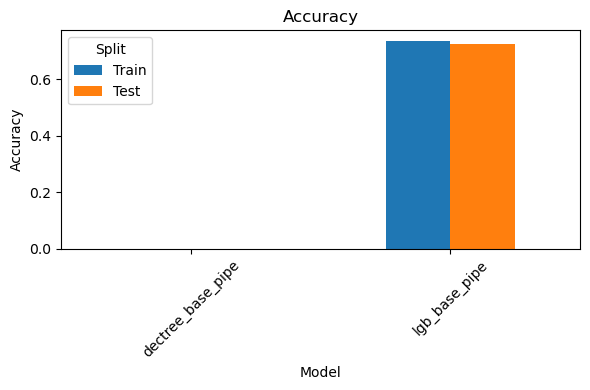

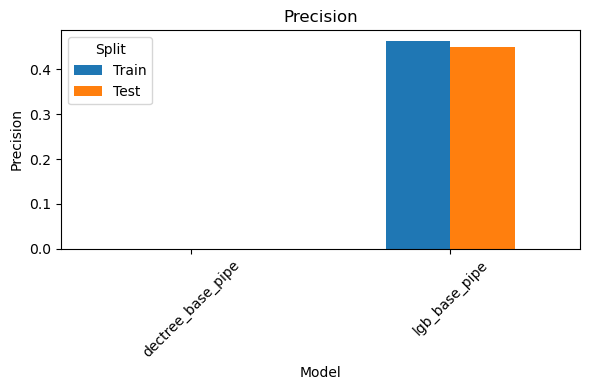

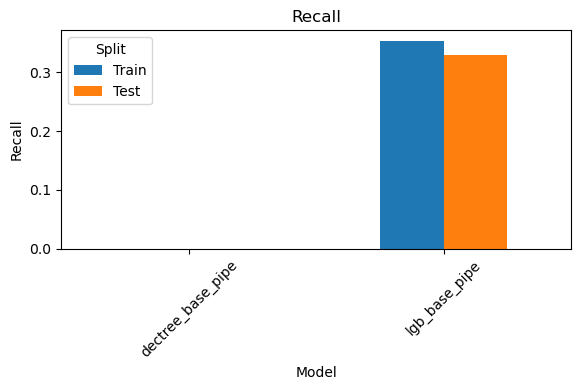

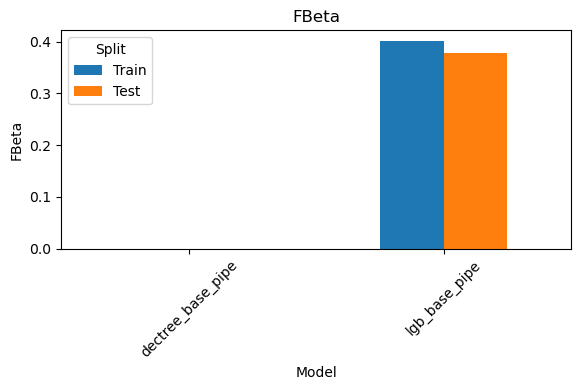

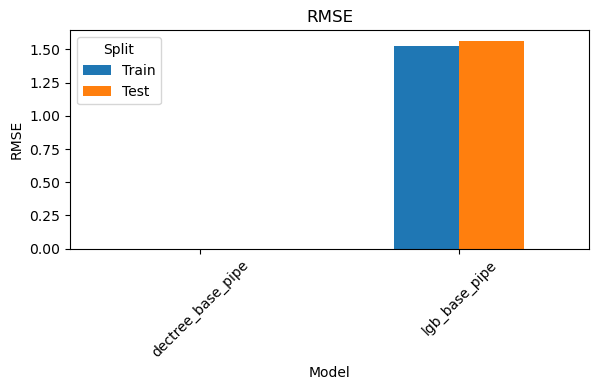

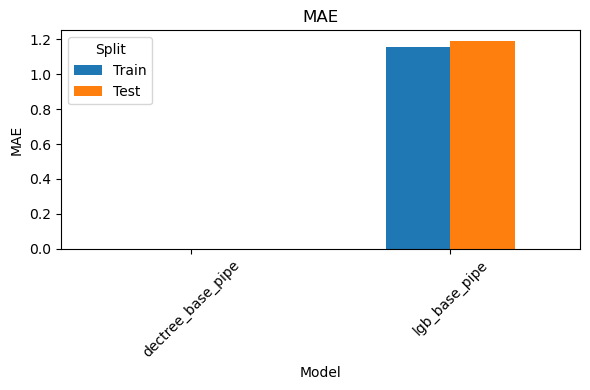

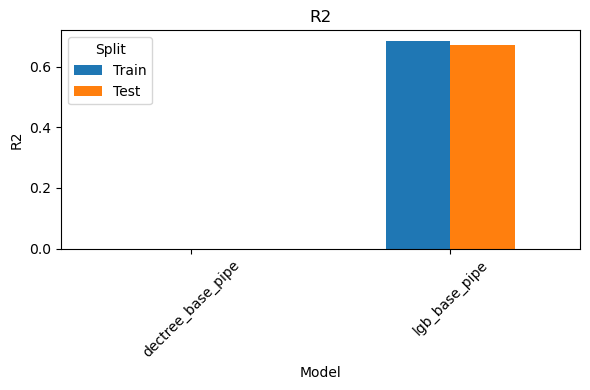

In [33]:


# 1) pick the models you want
selected_models = ['dectree_base_pipe', 'lgb_base_pipe']

# 2) filter
df_sel = df_models_eval[df_models_eval['Model'].isin(selected_models)]

# 3) metrics to plot
metrics = ['Accuracy','Precision','Recall','FBeta','RMSE','MAE','R2'] #'PR_AUC'

for metric in metrics:
    # 4) pivot so that Train/Test are columns
    df_piv = (
        df_sel
        .pivot(index='Model', columns='Split', values=metric)
        .reindex(selected_models)             # enforce the model order
    )
    
    # 5) simple grouped bar chart
    ax = df_piv[['Train','Test']].plot(
        kind='bar', 
        figsize=(6,4), 
        title=metric,
        rot=45
    )
    ax.set_ylabel(metric)
    plt.tight_layout()
    plt.show()


#### compare models in y y plots labeling them by both wrong, 1-wrong, 2-wrong, both right

In [34]:
# Collect R² values for each drug in the validation set
def plot_r2_per_drug(y_real, y_pred, model_name=None):
    r2_by_drug = []
    for drug_id in df_val['drug_id'].unique():
        idx = df_val['drug_id'] == drug_id
        if idx.sum() > 1:  # Need at least 2 samples to compute R²
            r2 = r2_score(y_real[idx], y_pred[idx])
            r2_by_drug.append(r2)

    # Plot histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(r2_by_drug, bins=60, kde=True)
    plt.xlabel("R² (per drug)")
    plt.ylabel("Count")
    plt.title(f"{model_name}: Histogram of R² values by drug (Validation Set)")
    plt.show()

In [35]:
print_df_markdown(df_models_eval)

| Model                | Split   | Model_Type   |   Time |   Accuracy |   Precision |   Recall |   FBeta |   PR_AUC |    RMSE |     MAE |           R2 |    Pearson |   Spearman |
|:---------------------|:--------|:-------------|-------:|-----------:|------------:|---------:|--------:|---------:|--------:|--------:|-------------:|-----------:|-----------:|
| dummy_regressor_pipe | Train   | regression   |  0.161 |    nan     |     nan     |  nan     | nan     |      nan | 2.71837 | 2.06473 |  0           | nan        | nan        |
| dummy_regressor_pipe | Test    | regression   |  0.029 |    nan     |     nan     |  nan     | nan     |      nan | 2.72659 | 2.07219 | -0.000230622 | nan        | nan        |
| lgb_base_pipe        | Train   | regression   |  0.969 |      0.736 |       0.464 |    0.354 |   0.402 |      nan | 1.52489 | 1.15935 |  0.685327    |   0.829403 |   0.757064 |
| lgb_base_pipe        | Test    | regression   |  0.079 |      0.724 |       0.449 |    0.329 |   0.379 

## Make paired plots for two models

Fix following code to compare many models into a subplot structure


--- Baseline Model Summary ---

LGBMRegressor : lgb_base_pipe y_val_data: y_val_reg


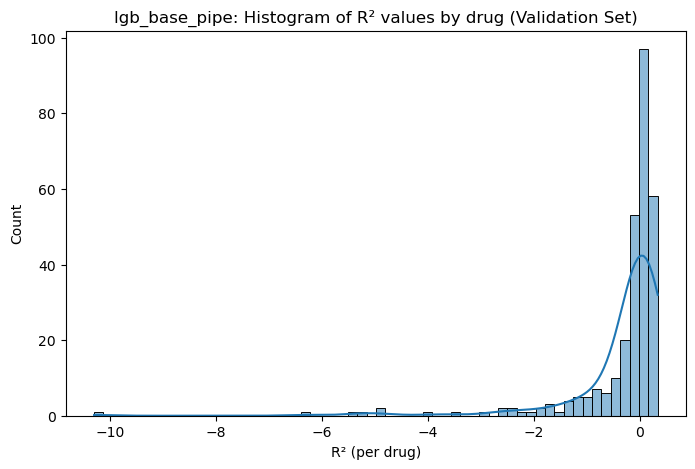

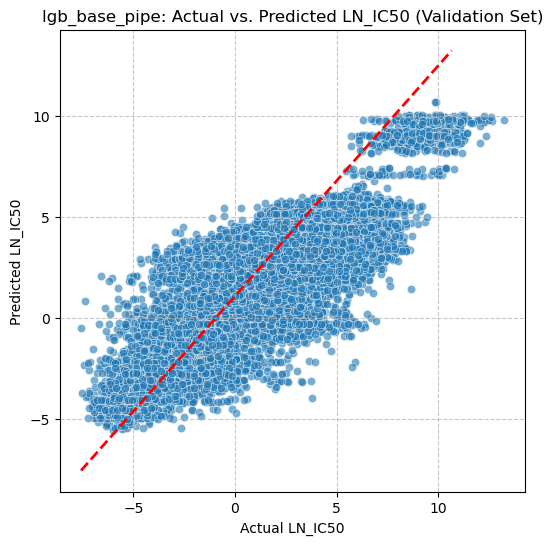

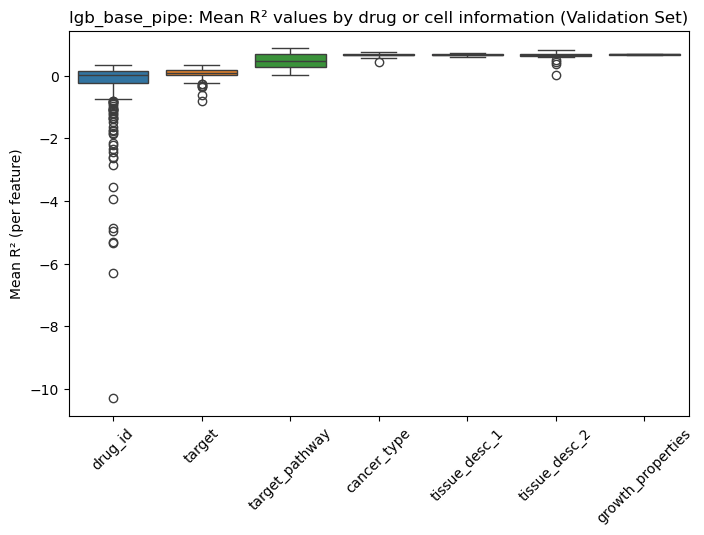

Plot y capped at -1 to 1 for Mean R2


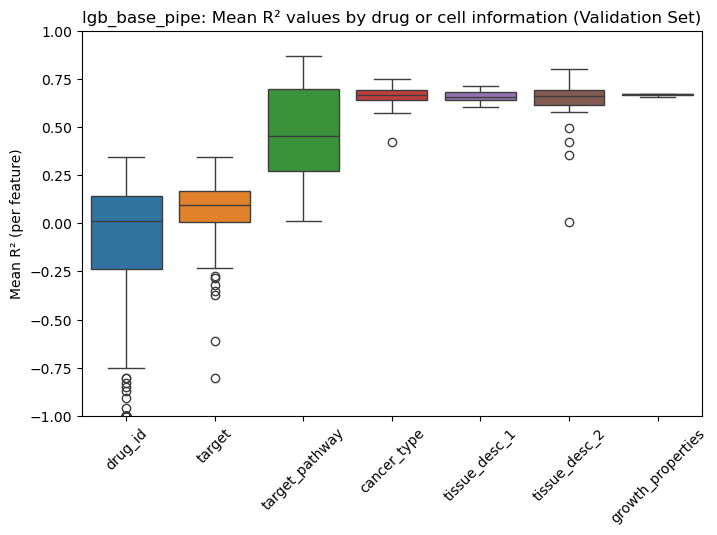

In [36]:
print("\n--- Baseline Model Summary ---")
models = {
    

}

model_name_1 = ['lgb_base_pipe']
model_to_eval_1 = lgb_base_pipe 
model_name_2 = 'linear_reg_model'
#model_to_eval_2 = linear_reg_model


y_pred_1 = model_to_eval_1.predict(X_val)
#y_pred_2 = model_to_eval_2.predict(X_val)


model_type_1 = df_model_info['model_type'][df_model_info['model_name'] == model_name].iloc[0]
val_data_y = df_model_info['val_data_y'][df_model_info['model_name'] == model_name].iloc[0]
print(f"\n{model_type}: {model_name} y_val_data: {val_data_y}")

# # raw coefficients:
# print(model_to_eval['model'].coef_)


if val_data_y == 'y_val_reg':
    # plot scatter for linear predictions

    plot_r2_per_drug(y_val_reg, y_pred_1, model_name=model_name)
    plot_scatter_relationship(y_val_reg, y_pred_1, title=f"{model_name}: Actual vs. Predicted LN_IC50 (Validation Set)")
    plot_r2_by_feature(df_val, y_val_reg, y_pred_1, model_name=model_name)#, floor=-20)
    print("Plot y capped at -1 to 1 for Mean R2")
    plot_r2_by_feature(df_val, y_val_reg, y_pred_1, floor=-1, model_name=model_name)

In [37]:
def plot_y_y_two_models(model_name_1, x, model_name_2, y):
    plt.scatter(x=x, y=y)
    plt.title(f"Prediction for {model_name_1} vs {model_name_2}")
    plt.xlabel(f"{model_name_1} Predictions")
    plt.ylabel(f"{model_name_2} Predictions")
    min_lim = np.floor(min(x.min(), y.min())) - 1
    max_lim = np.floor(max(x.max(), y.max())) + 1
    plt.xlim([min_lim, max_lim])
    plt.ylim([min_lim, max_lim])

    plt.plot([min_lim, max_lim], [min_lim, max_lim], 'r--', lw=2)  # y=x line
    plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect
    plt.grid(True)

    # Force x and y ticks to be the same
    # ticks = np.linspace(min_lim, max_lim, num=int((max_lim) - (min_lim) + 1))
    # plt.xticks(ticks)
    # plt.yticks(ticks)

#plot_y_y_two_models(model_name_1, y_pred_1, model_name_2, y_pred_2)

### QUESTION: What is the poor performance for some drugs (<= 0 and 0 < r2 < 0.5) related to?
- Number of samples in train set? 
    - Plot the r2 vs the number of cell lines by drug 

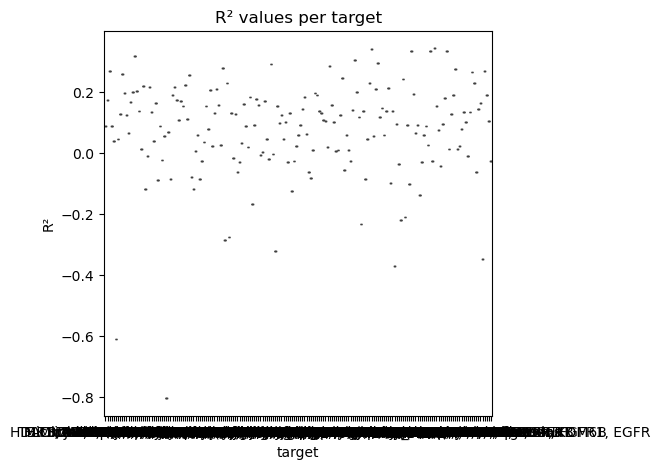

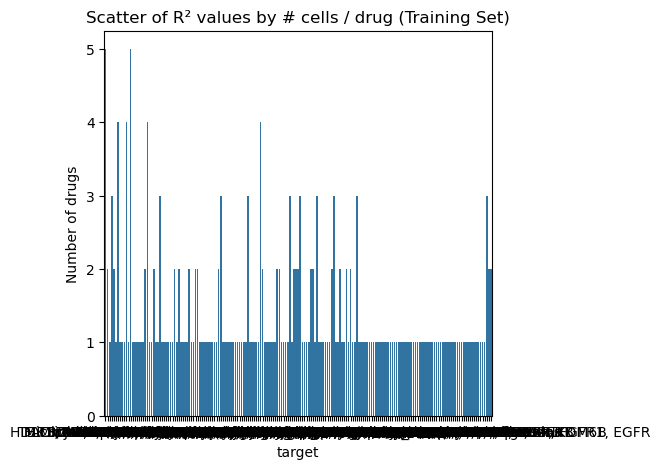

In [38]:
#
y_pred = y_pred_1 # remove this


#  build a table of r2 by drug, cosmic_id, cell info and drug info
keys = ['drug_id', 'r2', 'target', 'target_pathway', 'num_cells_test', 'num_cells_train', 'cancer_type', 'tissue_desc_1',
        'tissue_desc_2','growth_properties']
feature = 'target'
table_dict = {key: [] for key in keys}
feat_vals = []
r2_vals = []
n_samples = []
for feat_val in df_val[feature].unique():
    idx = (df_val[feature] == feat_val)
    #feat_vals.append(feat_val)
    if idx.sum() > 1:  # Need at least 2 samples to compute R²
        r2 = r2_score(y_val_reg[idx], y_pred[idx])
        #r2 = -1 if r2 < -1 else r2
        r2_vals.append(r2)
        feat_vals.append(feat_val)
        n_samples.append(df_val['drug_id'][idx].nunique())

    #else:
        #r2_vals.append(0)

# Plot scatter R2 by cells
plt.figure(figsize=(5, 5))
sns.boxplot( x=feat_vals, y=r2_vals, )
plt.title(f"R² values per {feature}")
plt.xlabel("# cell lines (per drug)")
plt.xlabel(feature)
plt.ylabel("R²")
plt.show()

# Plot scatter R2 by cells
plt.figure(figsize=(5, 5))
sns.barplot( x=feat_vals, y=n_samples, )
plt.title("Scatter of R² values by # cells / drug (Training Set)")
plt.xlabel("# cell lines (per drug)")
plt.ylabel("Number of drugs")
plt.xlabel(feature)
plt.show()

Interpretation and Questions:

Question:
- Was this model trained on the whole data set, or was it trained on each drug-id?

Interpreation:
- Many drugs underperform based on R2

In [39]:
# Check target pathway and other drug or cell (cancer_type) features
check_feature = 'drug_id'

# r2_by_feature = []
# for value in df_val[check_feature].unique():
#     idx = (df_val[check_feature] == value)
#     if idx.sum() > 1:
#         r2 = r
grp = df_val.groupby

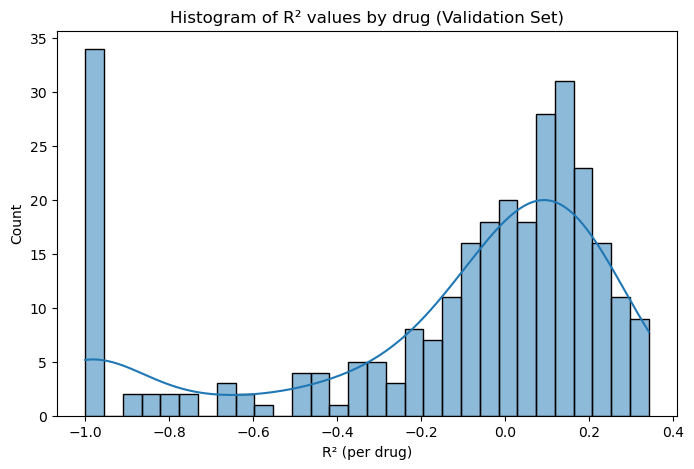

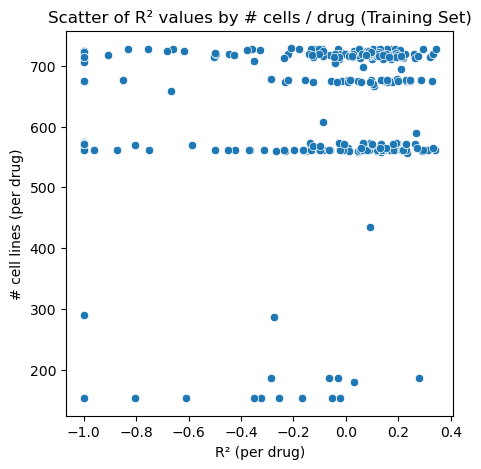

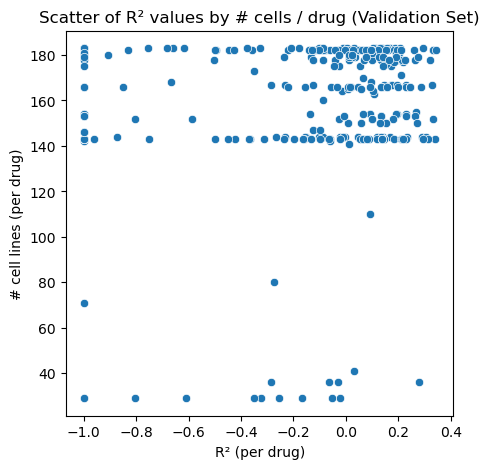

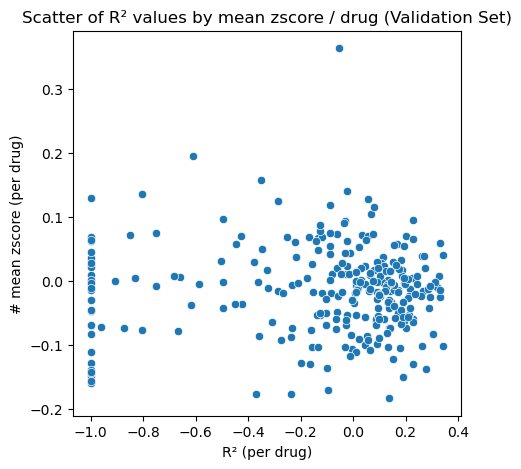

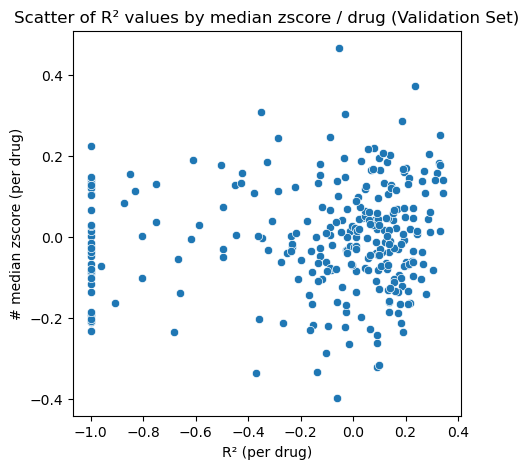

In [40]:
# Collect R² values for each drug in the validation set

r2_by_drug = []
cells_by_drug = []
cells_by_drug_train = []
mean_zscore_by_drug = []
median_zscore_by_drug = []
for drug_id in df_val['drug_id'].unique():
    idx = (df_val['drug_id'] == drug_id)
    if idx.sum() > 1:  # Need at least 2 samples to compute R²
        r2 = r2_score(y_val_reg[idx], y_pred[idx])
        r2 = -1 if r2 < -1 else r2
        r2_by_drug.append(r2)

        # number of cells
        unique_cell_test = df_val['COSMIC_ID'][idx].nunique()
        cells_by_drug.append(unique_cell_test)

        # get the trianing number of cells for this drug
        idx_train = (df_train['drug_id'] == drug_id)
        n_train_cells = df_train['COSMIC_ID'][idx_train].nunique()
        cells_by_drug_train.append(n_train_cells)

        mean_zscore_by_drug.append(df_val['z_score'][idx].mean())
        median_zscore_by_drug.append(df_val['z_score'][idx].median())
    
# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(r2_by_drug, bins=30, kde=True)
plt.xlabel("R² (per drug)")
plt.ylabel("Count")
plt.title("Histogram of R² values by drug (Validation Set)")
plt.show()

# Plot scatter R2 by cells
plt.figure(figsize=(5, 5))
sns.scatterplot( y=cells_by_drug_train, x=r2_by_drug,)
plt.xlabel("# cell lines (per drug)")
plt.xlabel("R² (per drug)")
plt.ylabel("# cell lines (per drug)")
plt.title("Scatter of R² values by # cells / drug (Training Set)")
plt.show()

# Plot scatter R2 by cells
plt.figure(figsize=(5, 5))
sns.scatterplot( y=cells_by_drug, x=r2_by_drug,)
plt.ylabel("# cell lines (per drug)")
plt.xlabel("R² (per drug)")
plt.ylabel("# cell lines (per drug)")
plt.title("Scatter of R² values by # cells / drug (Validation Set)")
plt.show()


# Plot scatter r2 by mean zscore
plt.figure(figsize=(5, 5))
sns.scatterplot( y=mean_zscore_by_drug, x=r2_by_drug,)
plt.ylabel("# cell lines (per drug)")
plt.xlabel("R² (per drug)")
plt.ylabel("# mean zscore (per drug)")
plt.title("Scatter of R² values by mean zscore / drug (Validation Set)")
plt.show()


# Plot scatter r2 by mean zscore
plt.figure(figsize=(5, 5))
sns.scatterplot( y=median_zscore_by_drug, x=r2_by_drug,)
plt.ylabel("# cell lines (per drug)")
plt.xlabel("R² (per drug)")
plt.ylabel("# median zscore (per drug)")
plt.title("Scatter of R² values by median zscore / drug (Validation Set)")
plt.show()

In [41]:
# build a table of r2 by drug, cosmic_id, cell info and drug info
keys = ['drug_id', 'r2', 'target', 'target_pathway', 'num_cells_test', 'num_cells_train', 'cancer_type', 'tissue_desc_1',
        'tissue_desc_2','growth_properties']
table_dict = {key: [] for key in keys}
for drug_id in df_val['drug_id'].unique():
    idx = (df_val['drug_id'] == drug_id)
    if idx.sum() > 1:  # Need at least 2 samples to compute R²
        r2 = r2_score(y_val_reg[idx], y_pred[idx])
        #r2 = -1 if r2 < -1 else r2
        table_dict['drug_id'].append(drug_id)
        table_dict['r2'].append(r2)
        table_dict['target'].append(df_val['target'][idx].unique())
        table_dict['target_pathway'].append(df_val['target_pathway'][idx].unique())


        table_dict['num_cells_test'].append(df_val['COSMIC_ID'][idx].nunique())
        # get the trianing number of cells for this drug
        idx_train = (df_train['drug_id'] == drug_id)
        n_train_cells = df_train['COSMIC_ID'][idx_train].nunique()
        table_dict['num_cells_train'].append(n_train_cells)

        table_dict['cancer_type'].append(df_val['cancer_type'][idx].unique())
        table_dict['tissue_desc_1'].append(df_val['tissue_desc_1'][idx].unique())
        table_dict['tissue_desc_2'].append(df_val['tissue_desc_2'][idx].unique())
        table_dict['growth_properties'].append(df_val['growth_properties'][idx].unique())

#print(table_dict)
r2_stats_df = pd.DataFrame(table_dict)

r2_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   drug_id            286 non-null    int64  
 1   r2                 286 non-null    float64
 2   target             286 non-null    object 
 3   target_pathway     286 non-null    object 
 4   num_cells_test     286 non-null    int64  
 5   num_cells_train    286 non-null    int64  
 6   cancer_type        286 non-null    object 
 7   tissue_desc_1      286 non-null    object 
 8   tissue_desc_2      286 non-null    object 
 9   growth_properties  286 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 22.5+ KB


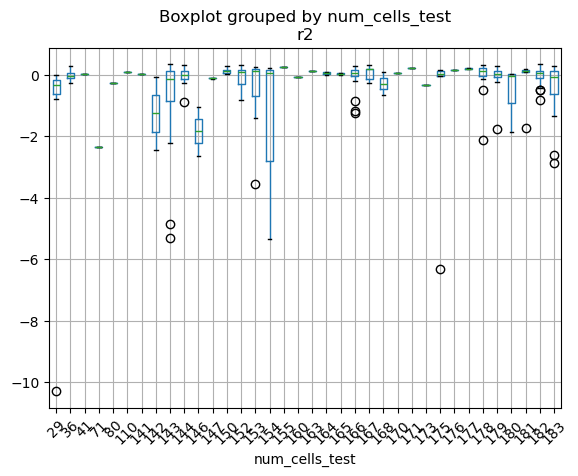

In [42]:
# Plot r2 dist by cell features

r2_stats_df.boxplot(column='r2', by='num_cells_test')
plt.xticks(rotation=45)
plt.show()


Interpretation:
The number of cells does not appear correlated to the level of model performance

In [43]:
print(df_model_info.model_type.unique())


['DummyRegressor' 'LGBMRegressor ']


# 4: Model Family Selection
Train a series of model types on core data and then select which model will be used for Feature Selection and final Model hypertuning.


| 	Model	 | 	Brief description / notes	 | 	Library	 | 
| 	--------	 | 	-----------	 | 	----------	 | 
| 	***Continuous-target (regression)***	 | 		 | 		 | 
| 	LGBMRegressor (baseline & optimized)	 | 	Gradient-boosted decision trees, native categorical support, fast on 100 k + rows	 | 	lightgbm	 | 
| 	XGBRegressor	 | 	Complementary GBDT implementation; often rivals/edges out LightGBM on tabular data	 | 	xgboost	 | 
| 	MLPRegressor	 | 	Feed-forward neural net (dense) – serves as the neural-network baseline	 | 	scikit-learn / PyTorch-TabNet	 | 
| 	***Binary-target (classification)***	 | 		 | 		 | 
| 	DecisionTreeClassifier 	 | 	Transparent baseline; matches your current pipeline	 | 	scikit-learn	 | 
| 	RandomForestClassifier	 | 	Stronger ensemble; handles class imbalance with class-weights	 | 	scikit-learn	 | 

## 4.1 LGBMRegressor: Addition of weights to LGBMRegressor model training

## 4.2 DecisionTree Baseline Model

## 4.3 XGBoost Core Data

objective: e.g. "reg:squarederror" for regression, "binary:logistic" for binary classification, or "multi:softprob" for multiclass.

In [ ]:
#%conda install -c conda-forge/label/cuda11.5 xgboost

## 4.4: MLPRegressor - Core Dataset

In [ ]:
## MLPRegressor - Core Dataset


### Normalize ln_i50 for neurla network

## 4.5 ElasticNet

## 5.X Final Selection of Model Family
Evaluate each of the core models and determine which to move to the next phase (Feature Selection)

Include:
- Table of results
- Visualization of model data in plots
- common error or model specific Y-Y plots


# 5.0 Feature Addition Experiment
Compare model performance with addition of Methylation, Mutation (Variant) and Expression Datasets


    The following combination of data sets will be used to evaluate the contribution of methylation, mutation and expression to with the GDSC on model performance.

| 	Condition	 | 	GDSC	 | 	Methylation (M)	 | 	Mutation (V)	 | 	Expression (E)	 | 
| 	--------	 | 	-----------	 | 	--------	 | 	-----------	 | 	----------	 | 
| 	Impact of GDSC only *	 | 	Y	 | 		 | 		 | 		 | 
| 	Impact of GDSC with M	 | 	Y	 | 	Y	 | 		 | 		 | 
| 	Impact of GDSC with M + V	 | 	Y	 | 	Y	 | 	Y	 | 		 | 
| 	Impact of GDSC with  M + E	 | 	Y	 | 	Y	 | 		 | 	Y	 | 
| 	Impact of GDSC with  M + V + E	 | 	Y	 | 	Y	 | 	Y	 | 	Y	 | 
  * Used for Base Models and Selection of the Best Model				


# 6.0 Final Model: Feature-selection & Hyper-tune (best feature combo)


## 6.1: Fine tune:


## 6.2: Train best hyper-tuned model: 

## 6.3: Final Feature slection with best hyper-tune model

### X.Y Feature selection with LGB  - No expression and no mutation data


### X.Y SHAP (no expression or mutation)

## 7.X Final Model Training with Final Selected Features

## 7.X_1 Save Models and data

In [ ]:
#df_models_eval.to_csv(MODELS_DIR / 'df_models_eval.csv', index=False)


# Write dataa into one .h5 file
with pd.HDFStore(MODELS_DIR / '05_modeling_datasets_advanced.h5', mode='w') as store:
    store['df_model_info'] = df_model_info
    store['df_models_eval'] = df_models_eval
    store['df_merged'] = df_merged
    store['df_train'] = df_train
    store['df_val'] = df_val
    store['X_train'] = X_train
    store['X_val'] = X_val
    store['y_train_reg'] = y_train_reg
    store['y_val_reg'] = y_val_reg
    store['y_train_cat'] = y_train_cat
    store['y_val_cat'] = y_val_cat
    store['w_train_series'] = pd.Series(w_train)
    store['w_val_series'] = pd.Series(w_val)
    # store['numerical_features'] = numerical_features
    # store['categorical_features'] = categorical_features

## 7.X Final Model Performance Stats and Visualization